In [10]:
from jqdatasdk import *
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from tensorflow.keras.layers import LSTM

#倒入一些必要的库
auth('18682404068','Huiye-520') #ID是申请时所填写的手机号；Password为聚宽官网登录密码，新申请用户默认为手机号后6位
get_query_count()#当前剩余可用数据条数

{'total': 500000, 'spare': 500000}

In [11]:
#get_industry_stocks('I64')# 获取计算机/互联网行业的成分股
#get_index_stocks('399951.XSHE', date=None)#获取沪深300银行指数成分股

In [12]:
#该函数能够获得指定时间，指定股票成分股的截面数据
def getdata(stock,datetime,gap):
    #调取截面数据、计算月收益率数据
    sample = get_index_stocks(stock, date=datetime)#股票除选择沪深300银行指数成分股
    q = query(valuation.code, 
              valuation.market_cap,#市值
              valuation.circulating_market_cap,
              balance.total_assets - balance.total_liability,#净资产
              balance.total_assets / balance.total_liability, 
              indicator.net_profit_to_total_revenue, #净利润/营业总收入
              indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
              balance.development_expenditure, #RD
              valuation.pe_ratio, #市盈率（TTM）
              valuation.pb_ratio, #市净率（TTM）
              indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
              balance.dividend_payable,
              indicator.roe,
              indicator.roa,
              income.operating_profit / income.total_profit, #OPTP
              indicator.gross_profit_margin, #销售毛利率GPM
              balance.fixed_assets / balance.total_assets, #FACR
              valuation.pcf_ratio, #CFP
              valuation.ps_ratio #PS
            ).filter(
                valuation.code.in_(sample)
            )
    df = get_fundamentals(q, date =datetime)
    #df.index = df.code.values
    del df['code']
    df = df.fillna(0)
    
    #解决数据日期问题 选取未来一个月的日期
    year = int(datetime[:4])
    month = int(datetime[5:7])
    day=int(datetime[8:10])
    if month == 12:       
        nexttime = str(year+1)+'-'+str(gap)+'-'+str(day)
    else:  
        nexttime = str(year)+'-'+str(month+gap)+'-'+str(day)
        
    #构建特征和标签
    sample2 = get_index_stocks(stock, date=nexttime)#股票除选择沪深300银行指数成分股
    q2 = query(valuation.code, 
              valuation.market_cap,#市值
            ).filter(
                valuation.code.in_(sample2)
            )
    df2=get_fundamentals(q2, date = nexttime)
    del df2['code']
    monthreturn=pd.DataFrame(df2['market_cap'].values/df['market_cap'].values, columns=['monthreturn'])
    df=pd.concat([df,monthreturn],axis=1)
    #df即为我们的训练集 用来训练回归模型 筛选变量和权重
    return df

In [13]:
#构建一个日期表，从这些日期中选取截面数据
def return_datelist(start_date,end_date):
    datelist=[]
    #start_date:str, 初始日期
    #end_date:str,终止日期
    start_year = int(start_date[:4])
    end_year = int(end_date[:4])
    start_month = int(start_date[5:7])
    end_month = int(end_date[5:7])
    start_day=int(start_date[8:10])
    end_day=int(end_date[8:10])
    for i in range(end_month):
        if(end_month-i<10):
            date=str(end_year)+'-'+'0'+str(end_month-i)+'-'+str(end_day)
            datelist=datelist+[date]
        else:
            date=str(end_year)+'-'+str(end_month-i)+'-'+str(end_day)
            datelist=datelist+[date]
    for i in range(13-start_month):
        if(start_month+i<10):
            date=str(start_year)+'-'+'0'+str(start_month+i)+'-'+str(start_day)
            datelist=datelist+[date]
        else:
            date=str(start_year)+'-'+str(start_month+i)+'-'+str(start_day)
            datelist=datelist+[date]          
        current_year=start_year+1
    while(current_year!=end_year):
        for i in range(11):
            if(i+1<10):
                date=str(current_year)+'-'+'0'+str(i+1)+'-'+str(start_day)
                datelist=datelist+[date]
            else:
                date=str(current_year)+'-'+str(i+1)+'-'+str(start_day)
                datelist=datelist+[date]
        current_year=current_year+1
    return datelist    

In [14]:
#获得训练数据集
start_date='2011-01-15'
end_date='2015-10-15'
monthgap=1
datelist=return_datelist(start_date=start_date,end_date=end_date)
#df=getdata(stock='399951.XSHE',datetime=start_date,gap=monthgap)
#for i in datelist:
#    dfnew=getdata(stock='399951.XSHE',datetime=i,gap=1)
#    df=pd.concat([df,dfnew],axis=0)
#df.shape

df = pd.read_csv('./Safe_and_reliable.csv',encoding='utf_8_sig')
print(df)   

     market_cap  circulating_market_cap        anon_1    anon_2   
0     1000.8977                606.6629  9.154200e+10  1.052748  \
1      258.6787                223.1250  2.466837e+10  1.058835   
2     1885.8660               1508.6927  1.890260e+11  1.057640   
3      667.8483                486.5765  8.266698e+10  1.058033   
4     2643.7275               2105.2195  1.912068e+11  1.059402   
..          ...                     ...           ...       ...   
395  13287.1475              10006.3320  1.432376e+12  1.076522   
396   1414.3766               1206.2539  1.731359e+11  1.071892   
397  10925.4795                419.2428  1.208180e+12  1.077808   
398   8637.6387               6053.7104  1.046257e+12  1.072749   
399   2372.1174               1617.5918  2.576849e+11  1.068023   

     net_profit_to_total_revenue  inc_revenue_year_on_year   
0                          31.23                     27.49  \
1                          41.99                     24.50   
2        

In [15]:
#借助训练集进行回归模型的训练 归一化数据
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
df1=min_max_scaler.fit_transform(df)
df2 = pd.DataFrame(df1, columns=df.columns)
df2.shape

(400, 19)

In [16]:
y=df2['monthreturn']
x=df2.drop(columns = ['monthreturn'])
x.shape,y.shape

((400, 18), (400,))

[-1.50791309e-01 -3.01123943e-02  1.35641495e-01  1.84825964e-01
 -3.19220289e-02  1.86087052e-01 -3.26128013e-16  1.43805304e-01
 -3.48143224e-01 -2.51465100e-01  3.73664433e-02  3.57709818e-01
 -3.08738743e-01  8.84743357e-02  1.11022302e-16  1.68525509e-02
 -4.87491950e-02 -6.84572108e-02]


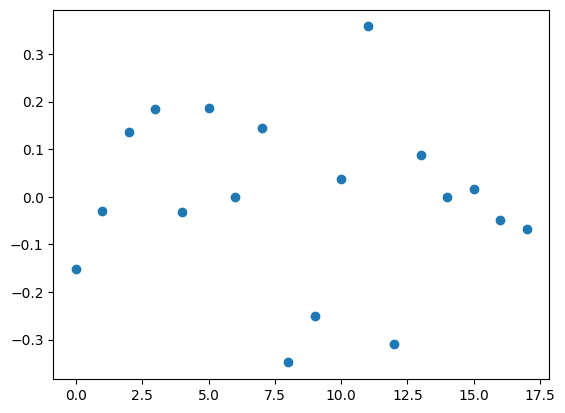

In [17]:
#利用线性模型得到权重
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x, y)
print(lr.coef_)
plt.plot(lr.coef_,'o', label = 'linear regression')

[-0.03241773 -0.01117482 -0.          0.23134316  0.08065063  0.27287154
  0.          0.         -0.09982297 -0.09187533  0.06622624  0.24833888
 -0.30440528  0.20254701  0.          0.05884     0.25657299 -0.15301863]


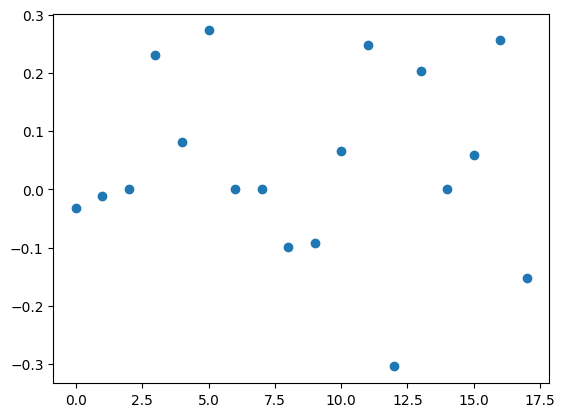

In [18]:
#利用线性模型得到权重
from sklearn.linear_model import Lasso
lasso = Lasso(fit_intercept=False)
lasso.set_params(alpha=0.0002)
lasso.fit(x, y)
print(lasso.coef_)
plt.plot(lasso.coef_,'o', label = 'linear regression')

[-0.02424564 -0.01344734  0.          0.02189964 -0.0048381   0.12457685
  0.         -0.         -0.15280154 -0.04719183  0.00196649 -0.00094741
 -0.00358401  0.023823    0.          0.01634503 -0.         -0.07826033]


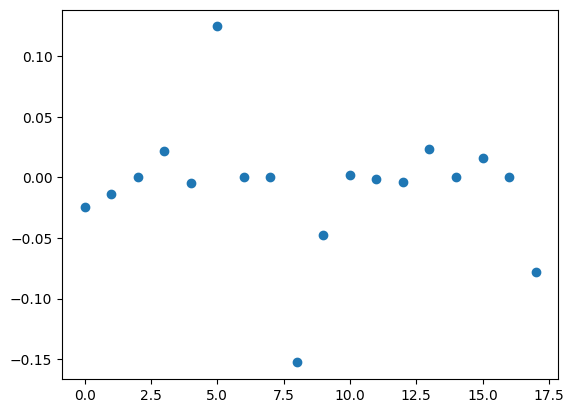

In [19]:
#利用线性模型得到权重
from sklearn.linear_model import ElasticNet
enet=ElasticNet(alpha=.005,l1_ratio=0.05)
enet.fit(x, y)
print(enet.coef_)
plt.plot(enet.coef_,'o', label = 'linear regression')

In [20]:
window=1
feanum=x.shape[1]
x=x.values
x=np.reshape(x, (x.shape[0],1, x.shape[1]))

In [24]:
#建立、训练模型过程
d = 0.01
model = Sequential()#建立层次模型
model.add(LSTM(16, input_shape=(window, feanum), return_sequences=True))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(LSTM(4, input_shape=(window, feanum), return_sequences=False))#建立LSTM层
model.add(Dropout(d))#建立的遗忘层
model.add(Dense(4,init='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,init='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.fit(x, y, nb_epoch =30, batch_size = 64) #训练模型nb_epoch次

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\Program Files (x86)\python\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\35107\AppData\Local\Temp\ipykernel_16236\480563920.py", line 11, in <module>
    model.fit(x, y, nb_epoch =30, batch_size = 64) #训练模型nb_epoch次
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Program Files (x86)\python\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "d:\Program Files (x86)\python\Lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.fit() got an unexpected keyword argument 'nb_epoch'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:

In [ ]:
#在训练集上的拟合结果
predict=model.predict(x)[:,0]

Text(0.5,1,'Train Data')

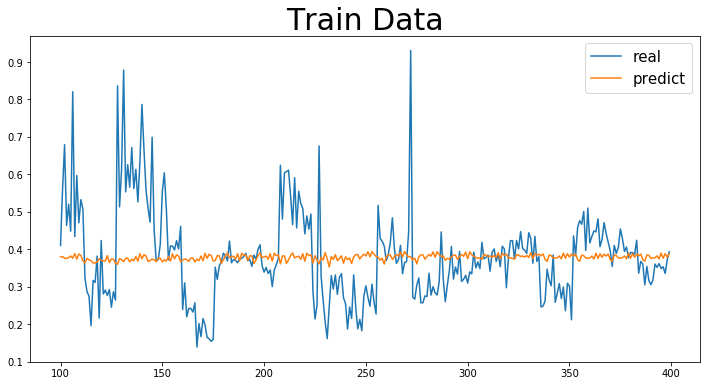

In [ ]:
draw=pd.concat([pd.DataFrame(y.values),pd.DataFrame(predict)],axis=1)
draw.iloc[100:400,0].plot(figsize=(12,6))
draw.iloc[100:400,1].plot(figsize=(12,6))
plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
plt.title("Train Data",fontsize='30') #添加标题
#展示在训练集上的表现 

In [ ]:
#开始模拟投资 读取当天的相关截面数据 预测收益率 并对股票按收益率排序
sample3 = get_index_stocks('399951.XSHE', date=None)#股票除选择沪深300银行指数成分股
q3 = query(valuation.code, 
          valuation.market_cap,#市值
          valuation.circulating_market_cap,
          balance.total_assets - balance.total_liability,#净资产
          balance.total_assets / balance.total_liability, 
          indicator.net_profit_to_total_revenue, #净利润/营业总收入
          indicator.inc_revenue_year_on_year,  #营业收入增长率（同比）
          balance.development_expenditure, #RD
          valuation.pe_ratio, #市盈率（TTM）
          valuation.pb_ratio, #市净率（TTM）
          indicator.inc_net_profit_year_on_year,#净利润增长率（同比）
          balance.dividend_payable,
          indicator.roe,
          indicator.roa,
          income.operating_profit / income.total_profit, #OPTP
          indicator.gross_profit_margin, #销售毛利率GPM
          balance.fixed_assets / balance.total_assets, #FACR
          valuation.pcf_ratio, #CFP
          valuation.ps_ratio #PS
        ).filter(
            valuation.code.in_(sample3)
        )
df = get_fundamentals(q3,date=None)
df.index = df.code.values
del df['code']
df = df.fillna(0)

In [ ]:
#实现预测+排序
min_max_scaler = preprocessing.MinMaxScaler()
df1=min_max_scaler.fit_transform(df)
df2 = pd.DataFrame(df1, columns=df.columns,index=df.index)
x=df2
x=x.values
x=np.reshape(x, (x.shape[0],1, x.shape[1]))
factor = pd.DataFrame(model.predict(x), index = df.index, columns = ['monthreturn'])
factor = factor.sort_index(by = 'monthreturn')#做了个排序
stockset = list(factor.index[:10])#选排名前十的股票

E:\anoconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  if __name__ == '__main__':


In [ ]:
stockset

['600015.XSHG',
 '601988.XSHG',
 '601229.XSHG',
 '601998.XSHG',
 '600926.XSHG',
 '601818.XSHG',
 '600016.XSHG',
 '601169.XSHG',
 '601328.XSHG',
 '600919.XSHG']